**1- Import Libraries**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd

**2- Load data**

In [3]:

# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data[:, :2]  # Only use the first two features for visualization
y = iris.target

# Transform target variable to binary classification (class 0 vs. non-class 0)
y_binary = np.where(y == 0, 0, 1)

**3- Apply pipelining and Grid search to tune hyper parameters:**

In [4]:

# Define a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

# Define the hyperparameters and the values we want to test
param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': [1, 0.1, 0.01, 0.001],
    'svc__kernel': ['rbf', 'linear' , 'poly']
}

# Create the StratifiedKFold object
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the GridSearchCV object with StratifiedKFold
grid = GridSearchCV(pipeline, param_grid, cv=stratified_kfold, refit=True)

# Fit the model using GridSearchCV
grid.fit(X, y_binary)

# Display the best parameters and scores from cross-validation
print("Best parameters found: ", grid.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))

# Evaluate the model using cross-validation
cv_results = cross_val_score(grid.best_estimator_, X, y_binary, cv=stratified_kfold)

# Display the cross-validation results
print("Cross-validation scores: ", cv_results)
print("Mean cross-validation accuracy: {:.2f}".format(cv_results.mean()))

Best parameters found:  {'svc__C': 0.1, 'svc__gamma': 1, 'svc__kernel': 'linear'}
Best cross-validation accuracy: 0.99
Cross-validation scores:  [1.         1.         0.96666667 1.         1.        ]
Mean cross-validation accuracy: 0.99


**4- Build the model with best parameters:**

In [5]:

# Split the data for a final test evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Train the final model on the full training set
final_model = grid.best_estimator_
final_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = final_model.predict(X_test)

# Display the results
print("Test set accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# To further analyze the grid search results
cv_results_df = pd.DataFrame(grid.cv_results_)
print("\nGrid Search CV Results:")
print(cv_results_df[['mean_test_score', 'std_test_score', 'params']])

Test set accuracy: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        20

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


Confusion Matrix:
[[10  0]
 [ 0 20]]

Grid Search CV Results:
    mean_test_score  std_test_score  \
0          0.980000        0.026667   
1          0.993333        0.013333   
2          0.973333        0.024944   
3          0.993333        0.013333   
4          0.993333        0.013333   
5          0.666667        0.000000   
6          0.666667        0.000000   
7          0.993333        0.013333   
8          0.666667        0.000000   
9          0.666667        0.000000   
10         0.993333        0.013333   
11         0.666667        0.000000   
12         0.993333        0.013333   
13         0.993

**5- Visualization of the data and boundaries:**

<ipython-input-6-7deb5149708e>:20: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


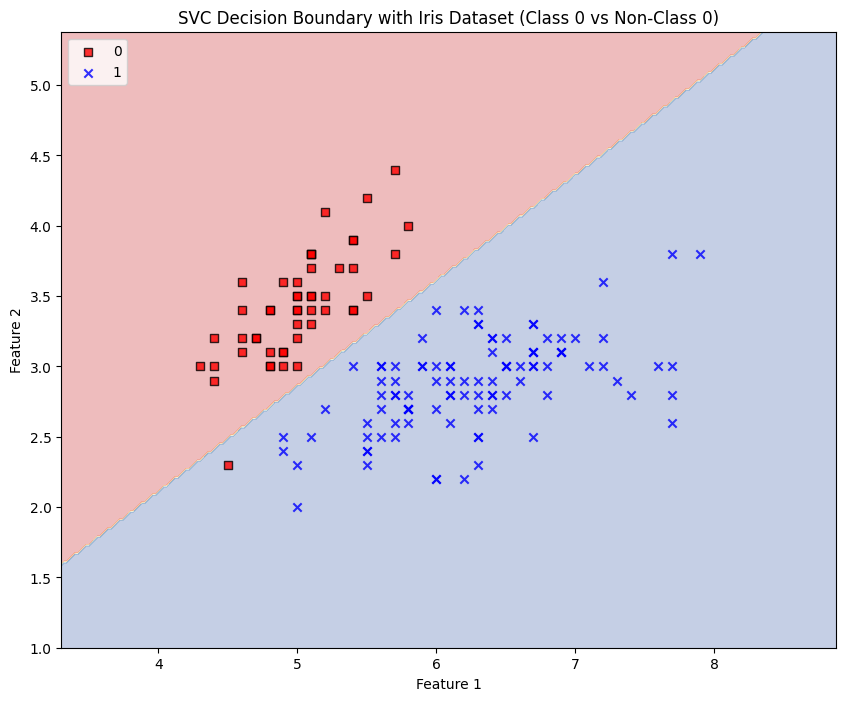

In [6]:
# Visualization
def plot_decision_regions(X, y, classifier, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = plt.cm.RdYlBu

    # Plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=cl, edgecolor='black')

# Plot the decision regions
plt.figure(figsize=(10, 8))
plot_decision_regions(X, y_binary, classifier=final_model)
plt.title('SVC Decision Boundary with Iris Dataset (Class 0 vs Non-Class 0)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='upper left')
plt.show()